In [1]:
#Import packages
#---------------------------------------
import sys
import os
from matplotlib import pyplot as plt
import numpy as np
import tension
import tensorflow as tf #NB MUST BE TF < 3.11
from tension.constrained import ConstrainedNoFeedbackESN, BioFORCEModel
from sklearn.decomposition import PCA
import pkg_resources
%load_ext autoreload

#Display versions
#--------------------------------------
pkg_resources.get_distribution("tensorflow").version
sys.version

# Define paths
#----------------------------------------------------------------------
s_data = '/mnlsc/data/MCBL4/dburrows/'
s_code = '~/Documents/multiscale_dev_dynamics'


2023-03-19 16:02:53.253270: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-19 16:02:53.415864: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-03-19 16:02:54.709657: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-03-19 16:02:54.709734: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or 

# Load data

In [ ]:
# Normalise!!!
# Filter out low SNR cells
# Gaussian smooth
# Find periods with highest SNR across recording -> choose a window
# Show low dim representation

In [84]:
#=======================================================================
def deltaff(mat, percentile):
#=======================================================================
    """
     This function calculates delta f/f for the trace by estimating a baseline as the nth lowest percentile of the data.
    
    Inputs:
    old_trace (np array): cells x fluorescence time points, raw trace
    percentile (int): percentile of data to take as baseline
    
    Returns:
    new_trace (np array): cells x fluorescebce time points, normalised trace

    """
    def dff_calc(old_trace, percentile):
        mini = np.min(old_trace)
        trace = old_trace - np.min(old_trace)
        newtrace = trace
        baseline = np.quantile(trace, percentile, axis= 0)
        newtrace[np.where(trace <= baseline)] = 0 #set all values below baseline to 0
        pos_index = np.where(trace > baseline) #indeces of values above baseline
        newtrace[pos_index] = (trace[pos_index] - baseline)/baseline
        return(newtrace)
    
    dff_mat = np.zeros(mat.shape)
    for i in range(mat.shape[0]):
        dff_mat[i] = dff_calc(mat[i], percentile)

    return(dff_mat)

In [51]:
import glob
os.chdir(s_data + '/dev/')
data_list = sorted(glob.glob('*regtrace*'))
data_list

['BLNDEV-WILDTYPE-01_2photon_sess-01-6dpf_BLNGR_run-01_regtrace.npy',
 'BLNDEV-WILDTYPE-02_2photon_sess-01-6dpf_BLNGR_run-01_regtrace.npy',
 'BLNDEV-WILDTYPE-03_2photon_sess-01-6dpf_BLNGR_run-01_regtrace.npy',
 'BLNDEV-WILDTYPE-04_2photon_sess-01-6dpf_BLNGR_run-01_regtrace.npy',
 'BLNDEV-WILDTYPE-06_2photon_sess-01-6dpf_BLNGR_run-01_regtrace.npy']

In [52]:
prac = np.load(data_list[0])

In [2]:
!wget https://data.mendeley.com/public-files/datasets/9936ryd5h7/files/7ac6616e-b6f7-4773-b254-b088147f68e6/file_downloaded 

--2023-03-19 16:02:57--  https://data.mendeley.com/public-files/datasets/9936ryd5h7/files/7ac6616e-b6f7-4773-b254-b088147f68e6/file_downloaded
Resolving data.mendeley.com (data.mendeley.com)... 162.159.133.86, 162.159.130.86
Connecting to data.mendeley.com (data.mendeley.com)|162.159.133.86|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://prod-dcd-datasets-public-files-eu-west-1.s3.eu-west-1.amazonaws.com/944fd3b3-cdd4-490d-a588-16392c862770 [following]
--2023-03-19 16:02:58--  https://prod-dcd-datasets-public-files-eu-west-1.s3.eu-west-1.amazonaws.com/944fd3b3-cdd4-490d-a588-16392c862770
Resolving prod-dcd-datasets-public-files-eu-west-1.s3.eu-west-1.amazonaws.com (prod-dcd-datasets-public-files-eu-west-1.s3.eu-west-1.amazonaws.com)... 52.218.97.179, 52.218.104.75, 3.5.66.119, ...
Connecting to prod-dcd-datasets-public-files-eu-west-1.s3.eu-west-1.amazonaws.com (prod-dcd-datasets-public-files-eu-west-1.s3.eu-west-1.amazonaws.com)|52.218.97.179|:44

In [35]:
with np.load('file_downloaded', allow_pickle=True) as data:
  keys = ['mask_name', 'cell_ids', 'tracez', 'all_coords']
  i = -4 # index corresponding to desired data 
  cell_id = list(data['cell_ids'])[i]  
  print(data['mask_name'][i])
  print(data['tracez'].shape)
  print(data['tracez'][cell_id].shape) 
  target = data['tracez'][cell_id] # based on cell_id's of neurons in desired area of brain
  target = target[:,:50]
target.shape

Telencephalon - Subpallium
(11190, 2500)
(365, 2500)


(365, 50)

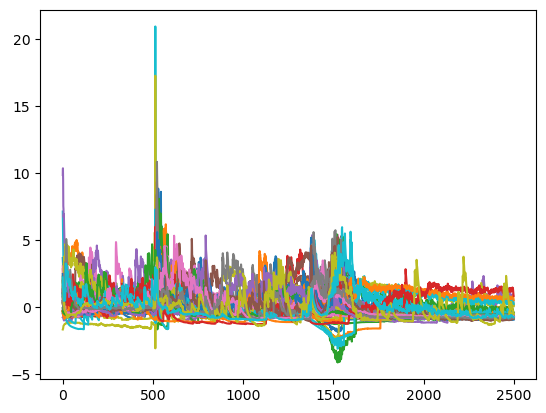

In [163]:
for i in range(50):
    plt.plot(target[i])
plt.show()

In [149]:
gf = 2
var = np.var(prac,axis=1)
input = prac[np.where(var > np.percentile(var, 98))[0]][:300]
dff = deltaff(input, 0.05)
dff = gaussian_filter1d(dff, gf, axis = 1)[:,1000:1100]
dff.shape

(300, 100)

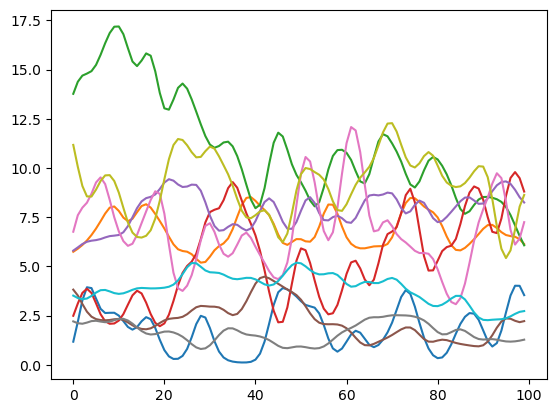

In [150]:
from scipy.ndimage import gaussian_filter1d
for i in range(10):
    plt.plot(dff[i])
plt.show()

# Define training parameters

In [91]:
target_transposed = np.transpose(target).astype(np.float32) # convert to shape (timestep, number of neurons)
u = 1 # number of inputs, by default the forward pass does not use inputs so this is a stand-in
n = target_transposed.shape[1] # number of neurons
tau = 1.5 # neuron time constant
dt = 0.25 # time step
alpha = 1 # gain on P matrix at initialization
m = n # output dim equals the number of recurrent neurons
g = 1.25 # gain parameter controlling network chaos
p_recurr = 0.5 # (1 - p_recurr) of recurrent weights are randomly set to 0 and not trained
max_epoch = 100

structural_connectivity = np.ones((n, n)) # region connectivity matrix; set to all 1's since only looking at one subsection of the brain
noise_param = (0, 0.001) # mean and std of white noise injected to the forward pass

x_t = np.zeros((target_transposed.shape[0], u)).astype(np.float32) # stand-in input

In [92]:
class EarlyStoppingByLossVal(tf.keras.callbacks.Callback):
    def __init__(self, monitor='val_loss', value=0.00001, verbose=0):
        super().__init__()
        self.monitor = monitor
        self.value = value
        self.verbose = verbose

    def on_epoch_end(self, epoch, logs={}):
        current = logs.get(self.monitor)
        
        if current < self.value:
            if self.verbose > 0:
                print("Epoch %05d: early stopping THR" % epoch)
            self.model.stop_training = True

# Train the model

In [38]:
x_t.shape, target_transposed.shape

((50, 1), (50, 365))

In [104]:
%%time
tf.random.set_seed(123)

earlystopping = EarlyStoppingByLossVal(monitor="val_mae", value=0.25)
esn_layer = ConstrainedNoFeedbackESN(units=n,
                                     activation='tanh',
                                     dtdivtau=dt/tau,
                                     p_recurr=p_recurr,
                                     structural_connectivity=structural_connectivity,
                                     noise_param=noise_param,
                                     seed=123)

model = BioFORCEModel(force_layer=esn_layer, alpha_P=alpha)
model.compile(metrics=["mae"])

# pass the input as validation data for early stopping
history = model.fit(x=x_t, 
                    y=target_transposed, 
                    epochs=max_epoch,
                    callbacks=[earlystopping],
                    validation_data=(x_t, target_transposed))

Epoch 1/100
50/50 [==============================] - 8s 158ms/step - mae: 0.9052 - val_loss: 2.1374 - val_mae: 2.1374
Epoch 2/100
50/50 [==============================] - 8s 166ms/step - mae: 0.5327 - val_loss: 0.4774 - val_mae: 0.4774
Epoch 3/100
50/50 [==============================] - 8s 154ms/step - mae: 0.3294 - val_loss: 0.3485 - val_mae: 0.3485
Epoch 4/100
50/50 [==============================] - 8s 159ms/step - mae: 0.2336 - val_loss: 1.5267 - val_mae: 1.5267
Epoch 5/100
50/50 [==============================] - 9s 175ms/step - mae: 0.1638 - val_loss: 1.3921 - val_mae: 1.3921
Epoch 6/100
50/50 [==============================] - 7s 148ms/step - mae: 0.1549 - val_loss: 0.4202 - val_mae: 0.4202
Epoch 7/100
50/50 [==============================] - 7s 142ms/step - mae: 0.1299 - val_loss: 0.3017 - val_mae: 0.3017
Epoch 8/100
50/50 [==============================] - 7s 144ms/step - mae: 0.1178 - val_loss: 0.2905 - val_mae: 0.2905
Epoch 9/100
50/50 [==============================] - 8s 

# Predict

In [105]:
%%time
prediction = model.predict(x_t)
print(tf.math.reduce_mean(tf.keras.metrics.mean_absolute_error(prediction, target_transposed)))

50/50 [==============================] - 0s 582us/step
tf.Tensor(0.21687108, shape=(), dtype=float32)
CPU times: user 238 ms, sys: 34.4 ms, total: 273 ms
Wall time: 201 ms


Text(0.5, 0, 'Time (s)')

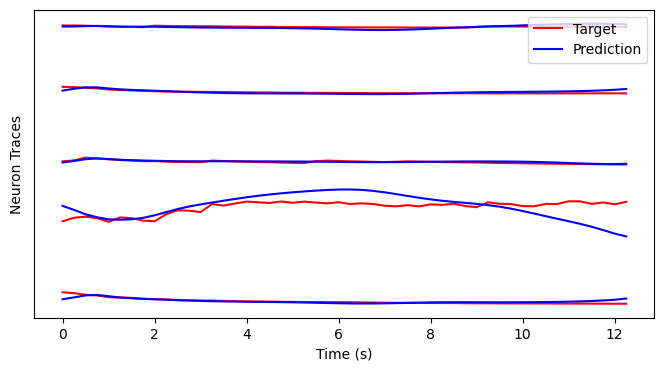

In [106]:
fig, ax = plt.subplots(1,1, figsize = (8,4))
num_plot = np.arange(5)

for idx, i in enumerate(num_plot):
  ax.plot(np.arange(0, x_t.shape[0]) * dt, target_transposed[:,i] + 10 * idx, color='r')
  ax.plot(np.arange(0, 50) * dt, prediction[:,i] + 10 * idx, color='b')
  if i == num_plot[-1]:
    ax.legend(['Target', 'Prediction'])
ax.set_yticks([])
ax.set_ylabel('Neuron Traces')
ax.set_xlabel('Time (s)')

Text(0, 0.5, 'PC2')

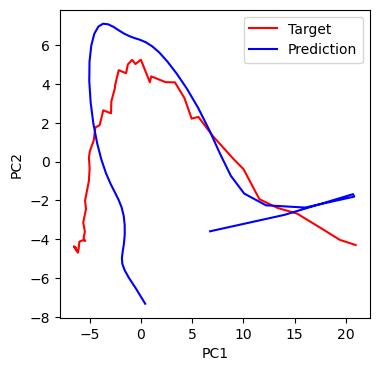

In [107]:
assert prediction.shape == target_transposed[:200].shape
pca = PCA(n_components=2)
target_pca = pca.fit_transform(target_transposed[:200])
pred_pca = pca.transform(prediction)
assert target_pca.shape == pred_pca.shape

plt.figure(figsize=(4,4))
plt.plot(target_pca[:,0], target_pca[:,1], color='r', label='Target')
plt.plot(pred_pca[:,0], pred_pca[:,1], color='b', label='Prediction')
plt.legend()
plt.xlabel('PC1')
plt.ylabel('PC2')

# Perturbation simulations

In [108]:
r_weights = esn_layer.recurrent_kernel
inp_weights = esn_layer.input_kernel
r_weights, inp_weights

(<tf.Variable 'rnn_7/constrained_no_feedback_esn_7/recurrent_kernel:0' shape=(365, 365) dtype=float32, numpy=
 array([[ 0.        , -0.28643897,  0.        , ...,  0.09336933,
          0.        , -0.0307191 ],
        [ 0.        ,  0.        , -0.16035251, ..., -0.26639014,
          0.        ,  0.        ],
        [ 0.        , -0.00274575,  0.        , ...,  0.        ,
         -0.10611878,  0.        ],
        ...,
        [-0.04807381,  0.        ,  0.        , ...,  0.        ,
         -0.16074912,  0.        ],
        [-0.05972771,  0.        ,  0.        , ..., -0.19677565,
          0.        , -0.13212039],
        [ 0.0756534 , -0.4313363 ,  0.        , ...,  0.        ,
          0.06207396,  0.        ]], dtype=float32)>,
 <tf.Variable 'rnn_7/constrained_no_feedback_esn_7/input_kernel:0' shape=(1, 365) dtype=float32, numpy=
 array([[-2.62937808e+00,  4.90205824e-01,  1.65878260e+00,
         -7.55360544e-01, -7.78516233e-02, -6.17132843e-01,
         -1.33415294e+0

In [98]:
prac = np.asarray(r_weights)
prac[0] = 1
prac

array([[ 1.        ,  1.        ,  1.        , ...,  1.        ,
         1.        ,  1.        ],
       [ 0.        ,  0.        , -0.16035251, ..., -0.26639014,
         0.        ,  0.        ],
       [ 0.        , -0.00274575,  0.        , ...,  0.        ,
        -0.10611878,  0.        ],
       ...,
       [-0.04807381,  0.        ,  0.        , ...,  0.        ,
        -0.16074912,  0.        ],
       [-0.05972771,  0.        ,  0.        , ..., -0.19677565,
         0.        , -0.13212039],
       [ 0.0756534 , -0.4313363 ,  0.        , ...,  0.        ,
         0.06207396,  0.        ]], dtype=float32)

In [114]:
prac = np.asarray(inp_weights)
prac+= 5
prac

array([[3.1706219, 6.290206 , 7.4587827, 5.0446396, 5.7221484, 5.182867 ,
        4.465847 , 5.680422 , 3.853853 , 6.2773075, 4.427032 , 5.5154095,
        5.406946 , 6.4203596, 5.8304253, 5.28785  , 7.001559 , 6.8651156,
        6.26184  , 4.2136183, 4.686938 , 6.043424 , 7.3441715, 5.8901787,
        5.732649 , 7.8536615, 5.355988 , 3.4608128, 6.3309574, 5.5644236,
        6.323783 , 5.482157 , 6.1201105, 3.7476196, 3.9512637, 5.5520263,
        5.611659 , 4.1644897, 7.1783094, 5.8421154, 5.5262485, 6.386204 ,
        5.6745796, 4.69211  , 4.499682 , 8.014609 , 6.617285 , 7.1808023,
        5.9337835, 6.8245153, 8.129367 , 5.5934668, 6.6001873, 6.0747566,
        5.530812 , 7.2228794, 7.1809707, 5.3651214, 5.3047557, 5.6962867,
        5.5618057, 5.6465883, 6.5228634, 6.399012 , 6.8758006, 6.206006 ,
        5.931895 , 5.6543403, 3.6140153, 4.9379816, 6.1641207, 6.816972 ,
        5.763196 , 5.7984924, 5.5163026, 5.375701 , 6.349229 , 7.003688 ,
        4.8103337, 4.664808 , 5.051764

In [115]:
esn_layer.recurrent_kernel.assign(prac) 
# esn_layer.input_kernel.assign(inp_weights1*2)

ValueError: Cannot assign value to variable ' rnn_7/constrained_no_feedback_esn_7/recurrent_kernel:0': Shape mismatch.The variable shape (365, 365), and the assigned value shape (1, 365) are incompatible.

In [116]:
#esn_layer.recurrent_kernel.assign(prac) 
esn_layer.input_kernel.assign(prac)

<tf.Variable 'UnreadVariable' shape=(1, 365) dtype=float32, numpy=
array([[3.1706219, 6.290206 , 7.4587827, 5.0446396, 5.7221484, 5.182867 ,
        4.465847 , 5.680422 , 3.853853 , 6.2773075, 4.427032 , 5.5154095,
        5.406946 , 6.4203596, 5.8304253, 5.28785  , 7.001559 , 6.8651156,
        6.26184  , 4.2136183, 4.686938 , 6.043424 , 7.3441715, 5.8901787,
        5.732649 , 7.8536615, 5.355988 , 3.4608128, 6.3309574, 5.5644236,
        6.323783 , 5.482157 , 6.1201105, 3.7476196, 3.9512637, 5.5520263,
        5.611659 , 4.1644897, 7.1783094, 5.8421154, 5.5262485, 6.386204 ,
        5.6745796, 4.69211  , 4.499682 , 8.014609 , 6.617285 , 7.1808023,
        5.9337835, 6.8245153, 8.129367 , 5.5934668, 6.6001873, 6.0747566,
        5.530812 , 7.2228794, 7.1809707, 5.3651214, 5.3047557, 5.6962867,
        5.5618057, 5.6465883, 6.5228634, 6.399012 , 6.8758006, 6.206006 ,
        5.931895 , 5.6543403, 3.6140153, 4.9379816, 6.1641207, 6.816972 ,
        5.763196 , 5.7984924, 5.5163026, 5.37

In [100]:
%%time
perturb_rw = model.predict(x_t)
print(tf.math.reduce_mean(tf.keras.metrics.mean_absolute_error(prediction, target_transposed)))

50/50 [==============================] - 0s 602us/step
tf.Tensor(0.21687108, shape=(), dtype=float32)
CPU times: user 103 ms, sys: 37.8 ms, total: 141 ms
Wall time: 85.5 ms


Text(0, 0.5, 'PC2')

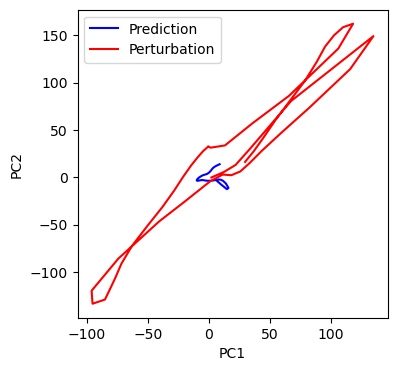

In [103]:
assert prediction.shape == target_transposed[:200].shape
pca = PCA(n_components=2)
target_pca = pca.fit_transform(prediction)
pred_pca = pca.transform(prediction)
perturb_pca = pca.transform(perturb_rw)

plt.figure(figsize=(4,4))
plt.plot(pred_pca[:,0], pred_pca[:,1], color='b', label='Prediction')
plt.plot(perturb_pca[:,0], perturb_pca[:,1], color='red', label='Perturbation')

plt.legend()
plt.xlabel('PC1')
plt.ylabel('PC2')

In [117]:
%%time
perturb_inp = model.predict(x_t)
print(tf.math.reduce_mean(tf.keras.metrics.mean_absolute_error(prediction, target_transposed)))

50/50 [==============================] - 0s 547us/step
tf.Tensor(0.21687108, shape=(), dtype=float32)
CPU times: user 146 ms, sys: 4.86 ms, total: 151 ms
Wall time: 95.2 ms


Text(0, 0.5, 'PC2')

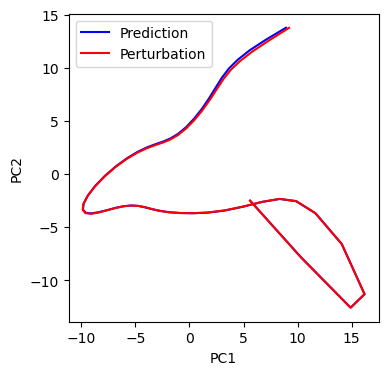

In [118]:
assert prediction.shape == target_transposed[:200].shape
pca = PCA(n_components=2)
target_pca = pca.fit_transform(prediction)
pred_pca = pca.transform(prediction)
perturb_pca = pca.transform(perturb_inp)

plt.figure(figsize=(4,4))
plt.plot(pred_pca[:,0], pred_pca[:,1], color='b', label='Prediction')
plt.plot(perturb_pca[:,0], perturb_pca[:,1], color='red', label='Perturbation')

plt.legend()
plt.xlabel('PC1')
plt.ylabel('PC2')

# Apply FORCE to 6dpf whole brain data